# General setup

In [1]:
import sys
import os
from pathlib import Path

# illustration2vec is not distributed as an actual Python module
# but as a directory with a bunch of stuff in it, so we need to
# add it to the PYTHONPATH manually.
I2V_ROOT = os.environ.get('ILLUSTRATION2VEC_PATH',
                          str(Path('.').resolve().parent))
if I2V_ROOT not in sys.path:
    sys.path.append(I2V_ROOT)

import i2v

illust2vec = i2v.make_i2v_with_chainer(
    os.path.join(I2V_ROOT, "illust2vec_tag_ver200.caffemodel"),
    os.path.join(I2V_ROOT, "tag_list.json"))

In [72]:
def group(it, *, size=10):
    """Group an iterable in chunks of the same size.
    
    >>> list(group([1, 2, 3, 4], size=2))
    [[1, 2], [3, 4]]
    >>> list(group([1, 2, 3, 4], size=3))
    [[1, 2, 3], [4]]
    
    Args:
        it: An iterable to split.
        size: The size of each chunk. Note that the last chunk
            may be smaller if the length of `it` is not divisible
            by `size`.
            
    Returns:
        An iterable of list of elements from `it` where each chunk,
        except possibly the last, have length `size`. 
    """

    # Ensure `it` is an iterator
    it = iter(it)
    stopped = False
    while not stopped:
        chunk = []
        for i in range(size):
            try:
                chunk.append(next(it))
            except StopIteration:
                # We need to handle the last chunk separately.
                if chunk:
                    yield chunk
                return
        yield chunk

In [73]:
import functools
import random
from tqdm import tqdm_notebook
from PIL import Image
from IPython.display import display
import ipywidgets as widgets
import pandas as pd        
import numpy as np


def build_slot(state, paths_it):
    path = next(paths_it)
    with open(path, 'rb') as f:
        image = widgets.Image(
            value=f.read(),
            format='jpeg',
            layout=widgets.Layout(width='320px', margin='auto 0 0 0'),
            continuous_update=True,
        )
    label = widgets.Label(
        value=os.path.basename(path),
        layout=widgets.Layout(margin='0 auto'),
    )
    sfw_button = widgets.Button(
        description='SFW',
        button_style='success',
        layout=widgets.Layout(width='100%', margin='0 0 2px 0'),
    )
    nsfw_button = widgets.Button(
        description='NSFW',
        button_style='danger',
        layout=widgets.Layout(width='100%', margin='0 0 2px 0'),
    )

    vbox = widgets.VBox(
        [label, widgets.HBox([sfw_button, nsfw_button]), image])

    def on_button_click(b, *, nsfw):
        state[label.value] = nsfw
        try:
            path = next(paths_it)
        except StopIteration:
            vbox.close()
        else:
            with open(path, 'rb') as f:
                image.value = f.read()
            label.value = os.path.basename(path)

    sfw_button.on_click(functools.partial(on_button_click, nsfw=False))
    nsfw_button.on_click(functools.partial(on_button_click, nsfw=True))

    return vbox

class Dataset:
    works_json = 'mangaki_i2v.json'
    nsfw_csv = 'mangaki_nsfw.csv'
    
    def __init__(self, path):
        self._path = path
        self._names = os.listdir(path)
        random.shuffle(self._names)
        self._state = {}
        self._works = {}
        
    def to_dataframes(self):
        state_df = pd.DataFrame({'nsfw': self._state})

        tag_groups = {}
        for name, tags in self._works.items():
            for group, values in tags.items():
                tag_groups.setdefault(group, set()).update(set(dict(values)))
        columns = [
            np.array(sum([[group] * len(values) for group, values in tag_groups.items()], [])),
            np.array(sum([list(values) for values in tag_groups.values()], [])),
        ]

        rev_columns = {}
        for j, (group, tag) in enumerate(zip(*columns)):
            rev_columns[(group, tag)] = j

        raw = np.zeros((len(self._works), len(index[0])))
        for work_index, work in enumerate(self._works.values()):
            for group, tags in work.items():
                for tag_name, tag_value in tags:
                    raw[work_index, rev_columns[(group, tag_name)]] = tag_value
        works_df = pd.DataFrame(raw, index=list(dataset._works.keys()), columns=index)
        
        return works_df, state_df
        
    def restore_from_cache(self, cache_dir):
        works_path = Path(cache_dir) / self.works_json
        if works_path.exists():
            with works_path.open('r') as f:
                self._works.update(json.load(f))
                
        nsfw_path = Path(cache_dir) / self.nsfw_csv
        if nsfw_path.exists():
            old_state = pd.read_csv(str(nsfw_path), index_col=0).to_dict()['nsfw']
            self._state = {**old_state, **self._state}
            
    def save_to_cache(self, cache_dir):
        nsfw_path = Path(cache_dir) / self.nsfw_csv
        if nsfw_path.exists():
            raise FileExistsError(str(nsfw_path))
        pd.DataFrame({'nsfw': self._state}).to_csv(str(nsfw_path))
        
        works_path = Path(cache_dir) / self.works_json
        if works_path.exists():
            raise FileExistsError(str(works_path))
        with works_path.open('w') as f:
            json.dump(self._works, f)
            
    def process(self, *, batch_size=4):
        paths = [
            os.path.join(self._path, name)
            for name in self._names
            if name not in self._works
        ]

        total = (len(paths) + batch_size - 1) // batch_size
        chunks_it = group(paths, size=batch_size)
        for n_batches, chunk in tqdm_notebook(enumerate(chunks_it), total=total):
            results = illust2vec.estimate_plausible_tags(
                [Image.open(path) for path in chunk])
            for path, result in zip(chunk, results):
                self._works[os.path.basename(path)] = result
        
    @property
    def state(self):
        return dict(self._state)
        
    def _mk_iter(self):
        for name in self._names:
            if name in self._state:
                continue
            yield os.path.join(self._path, name)
        
    def build(self, *, num_slots=1):
        paths_it = self._mk_iter()
        hbox = widgets.HBox([
            build_slot(self._state, paths_it)
            for _ in range(num_slots)
        ], layout=widgets.Layout(flex_flow='wrap', justify_content='center'))
        
        return hbox

In [74]:
dataset = Dataset('/data/elarnon/mangaki_posters/')
dataset.restore_from_cache('/home/elarnon/code/illustration2vec')
dataset.process()
display(dataset.build())

In [75]:
works, nsfw = dataset.to_dataframes()

# NSFW prediction

# Estimation of relevant features using ElasticNet

In [78]:
from sklearn.linear_model import ElasticNetCV

In [130]:
en = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1]).fit(works.loc[nsfw.index]['rating'], nsfw['nsfw'])

In [131]:
en.coef_

array([ 0.90103001,  1.55975775,  0.13681478])

In [98]:
np.argmax(en.predict(works['rating']))

11853

In [153]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

sk = SelectKBest(chi2, k=8).fit(works.loc[nsfw.index], nsfw['nsfw'])

In [119]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
X = works.loc[nsfw.index]
sfm = SelectFromModel(clf, threshold=0.25)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

In [170]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

svc = LogisticRegression()
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(3),
              scoring='accuracy')
rfecv.fit(works.loc[nsfw.index], nsfw['nsfw'])

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

In [154]:
works.columns.droplevel()[sk.get_support()]

Index(['panties', 'breasts', 'large breasts', 'underwear', 'cleavage',
       'thighhighs', 'questionable', 'safe'],
      dtype='object')

In [171]:
works.columns.droplevel()[rfecv.support_]

Index(['cover', 'swimsuit', 'panties', 'breasts', 'underwear', 'long hair',
       'questionable', 'safe'],
      dtype='object')

In [162]:
from sklearn.linear_model import SGDClassifier

In [191]:
nsfw.loc[nsfw.index][rfecv.predict(works.loc[nsfw.index]) != nsfw['nsfw']]

,nsfw
11289.jpg,False
11532.jpg,False
3891.jpg,True
6078.jpg,True
6335.jpg,False
7704.jpg,True
8280.jpg,False


In [193]:
rfecv.predict_proba(works.loc[nsfw.index].loc[nsfw.loc[nsfw.index][rfecv.predict(works.loc[nsfw.index]) == nsfw['nsfw']].index])

array([[ 0.75979779,  0.24020221],
       [ 0.9023085 ,  0.0976915 ],
       [ 0.93002753,  0.06997247],
       [ 0.8156972 ,  0.1843028 ],
       [ 0.94366673,  0.05633327],
       [ 0.77466617,  0.22533383],
       [ 0.90552557,  0.09447443],
       [ 0.13576115,  0.86423885],
       [ 0.07685201,  0.92314799],
       [ 0.02376097,  0.97623903],
       [ 0.29890678,  0.70109322],
       [ 0.70773397,  0.29226603],
       [ 0.78506449,  0.21493551],
       [ 0.05412869,  0.94587131],
       [ 0.02738885,  0.97261115],
       [ 0.38787016,  0.61212984],
       [ 0.27076544,  0.72923456],
       [ 0.04556622,  0.95443378],
       [ 0.15148066,  0.84851934],
       [ 0.8636072 ,  0.1363928 ],
       [ 0.13756096,  0.86243904],
       [ 0.57917077,  0.42082923],
       [ 0.13831246,  0.86168754],
       [ 0.80424389,  0.19575611],
       [ 0.20244544,  0.79755456],
       [ 0.02642554,  0.97357446],
       [ 0.24446846,  0.75553154],
       [ 0.33051438,  0.66948562],
       [ 0.21039783,

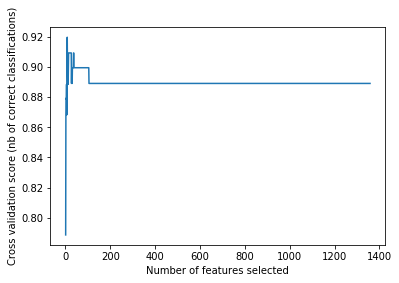

In [172]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [185]:
widgets.Image(value=open('/data/elarnon/mangaki_posters/8280.jpg', 'rb').read(), width=300)

In [101]:
nsfw.loc['5819.jpg']

KeyError: 'the label [5819.jpg] is not in the [index]'